# Introduction to Neural Networks with TensorFlow and Keras Layers

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [7]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0  90235      0 --:--:-- --:--:-- --:--:-- 90235


In [8]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [9]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [10]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000,0.998667
std,17.604333,17.191727,15.463152,0.816768
min,68.000000,9.000000,-21.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,102.000000,84.000000,2.000000


In [11]:
# we deliberately decide this is going to be our label, it is often called lower case y
y = df['group']

In [12]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [13]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [17]:
# we have (almost) the same number of samples per categoery in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [18]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [48]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
        

### Plotting our data to get an overview

We plot each data sample to get an idea of the training data
* x axis: age of driver
* y axis: max speed

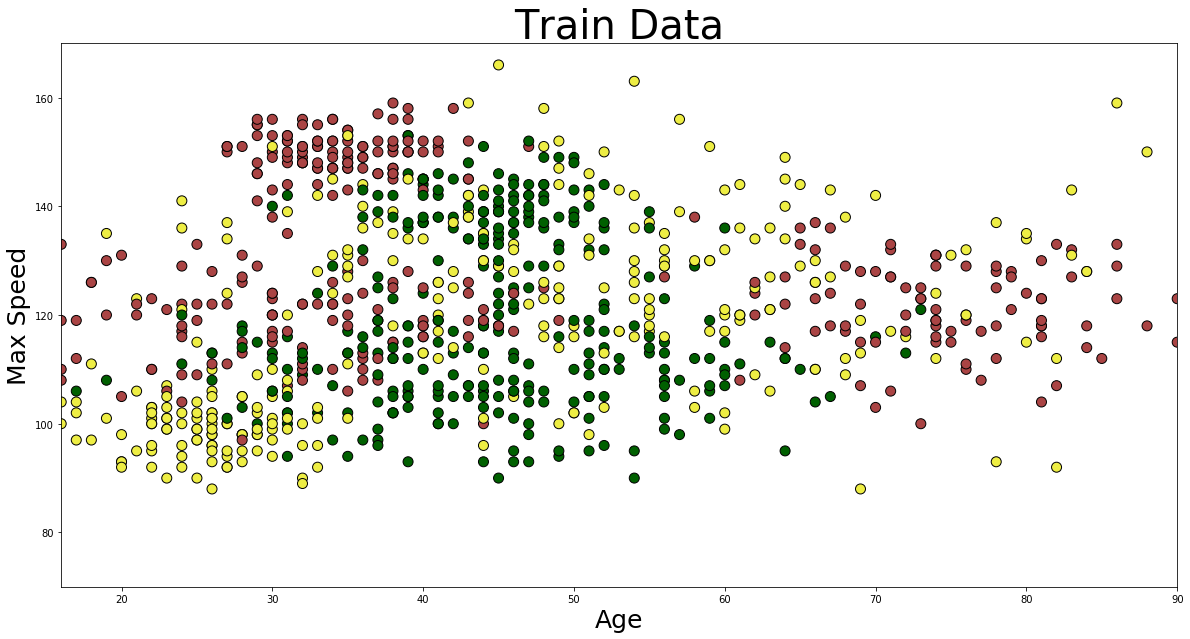

In [49]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

### A small exercise

* download the above plot of samples (https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/exercise/manual-decision-boundaries.pdf)
* work with your mouse or a digital pen in your favorite image editor
* draw decision boundaries to separate the different groups from each other
* try to minimize the number of falsely classified samples
* mark each section with what color you would precit for it
* use as few and as smooth lines as possible


### Same plot for test data
* note that we can see different areas
* how well would your decision boundaries work for that test data?
* be honest to yourself: were you overfiting?

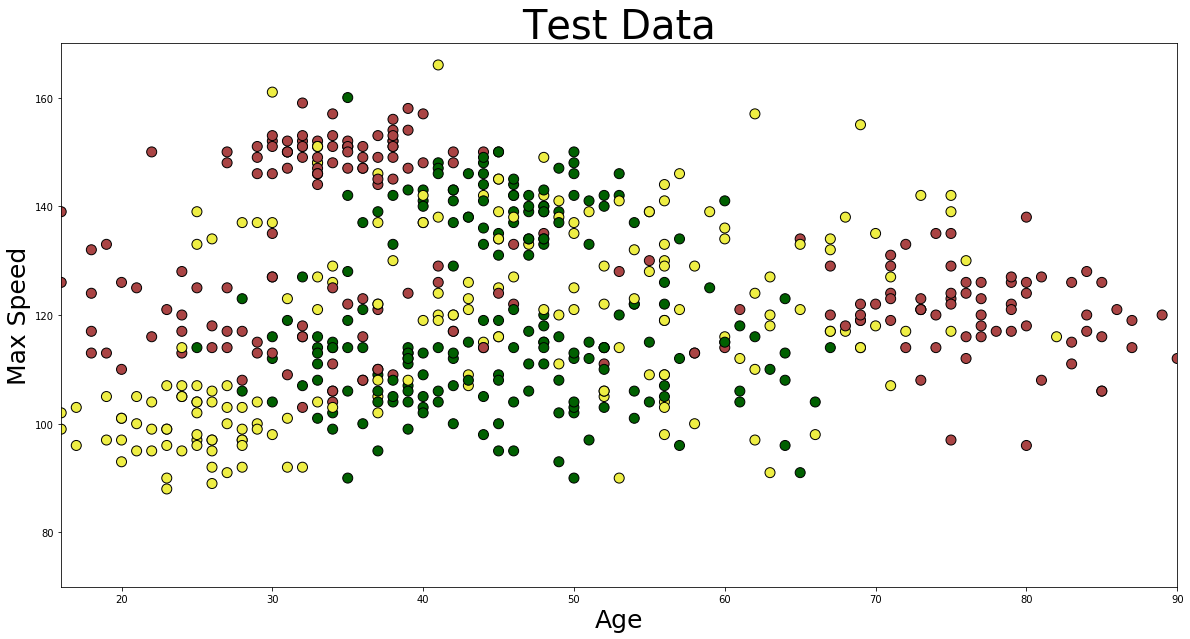

In [50]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [22]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [23]:
model = tf.keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity

In [24]:
model.add(tf.keras.layers.Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(tf.keras.layers.Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [25]:
model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [28]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [30]:
BATCH_SIZE=1000
EPOCHS = 5000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6642 - acc: 0.7222 - val_loss: 0.7821 - val_acc: 0.6722
Epoch 2/5000
720/720 [==============================] - 0s 12us/step - loss: 0.6636 - acc: 0.7292 - val_loss: 0.7827 - val_acc: 0.6667
Epoch 3/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6636 - acc: 0.7222 - val_loss: 0.7850 - val_acc: 0.6667
Epoch 4/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6640 - acc: 0.7208 - val_loss: 0.7831 - val_acc: 0.6611
Epoch 5/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6641 - acc: 0.7236 - val_loss: 0.7853 - val_acc: 0.6667
Epoch 6/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6639 - acc: 0.7208 - val_loss: 0.7823 - val_acc: 0.6722
Epoch 7/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6634 - acc: 0.7236 - val_loss: 0.7826 - val_acc: 0.6667
Epoch 8/5

Epoch 62/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6610 - acc: 0.7153 - val_loss: 0.7846 - val_acc: 0.6722
Epoch 63/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6619 - acc: 0.7167 - val_loss: 0.7899 - val_acc: 0.6667
Epoch 64/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6641 - acc: 0.7111 - val_loss: 0.7865 - val_acc: 0.6667
Epoch 65/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6650 - acc: 0.7167 - val_loss: 0.7961 - val_acc: 0.6667
Epoch 66/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6680 - acc: 0.7139 - val_loss: 0.7872 - val_acc: 0.6611
Epoch 67/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6668 - acc: 0.7153 - val_loss: 0.7979 - val_acc: 0.6667
Epoch 68/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6679 - acc: 0.7194 - val_loss: 0.7834 - val_acc: 0.6611
Epoch 69/5000
720/720 [==============================

Epoch 123/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6531 - acc: 0.7181 - val_loss: 0.7794 - val_acc: 0.6667
Epoch 124/5000
720/720 [==============================] - 0s 21us/step - loss: 0.6526 - acc: 0.7222 - val_loss: 0.7815 - val_acc: 0.6722
Epoch 125/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6520 - acc: 0.7236 - val_loss: 0.7805 - val_acc: 0.6722
Epoch 126/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6516 - acc: 0.7292 - val_loss: 0.7793 - val_acc: 0.6556
Epoch 127/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6512 - acc: 0.7264 - val_loss: 0.7808 - val_acc: 0.6722
Epoch 128/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6510 - acc: 0.7250 - val_loss: 0.7772 - val_acc: 0.6611
Epoch 129/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6507 - acc: 0.7236 - val_loss: 0.7803 - val_acc: 0.6667
Epoch 130/5000
720/720 [===================

Epoch 183/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6506 - acc: 0.7208 - val_loss: 0.7757 - val_acc: 0.6611
Epoch 184/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6473 - acc: 0.7292 - val_loss: 0.7802 - val_acc: 0.6611
Epoch 185/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6450 - acc: 0.7194 - val_loss: 0.7775 - val_acc: 0.6556
Epoch 186/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6442 - acc: 0.7292 - val_loss: 0.7760 - val_acc: 0.6611
Epoch 187/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6448 - acc: 0.7292 - val_loss: 0.7826 - val_acc: 0.6667
Epoch 188/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6463 - acc: 0.7208 - val_loss: 0.7752 - val_acc: 0.6556
Epoch 189/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6480 - acc: 0.7292 - val_loss: 0.7860 - val_acc: 0.6722
Epoch 190/5000
720/720 [=====================

Epoch 243/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6408 - acc: 0.7236 - val_loss: 0.7765 - val_acc: 0.6667
Epoch 244/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6410 - acc: 0.7292 - val_loss: 0.7785 - val_acc: 0.6722
Epoch 245/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6409 - acc: 0.7264 - val_loss: 0.7747 - val_acc: 0.6667
Epoch 246/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6411 - acc: 0.7264 - val_loss: 0.7793 - val_acc: 0.6722
Epoch 247/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6411 - acc: 0.7264 - val_loss: 0.7732 - val_acc: 0.6611
Epoch 248/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6418 - acc: 0.7250 - val_loss: 0.7812 - val_acc: 0.6722
Epoch 249/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6420 - acc: 0.7222 - val_loss: 0.7732 - val_acc: 0.6611
Epoch 250/5000
720/720 [==================

Epoch 303/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6343 - acc: 0.7361 - val_loss: 0.7766 - val_acc: 0.6667
Epoch 304/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6340 - acc: 0.7333 - val_loss: 0.7717 - val_acc: 0.6667
Epoch 305/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6341 - acc: 0.7306 - val_loss: 0.7766 - val_acc: 0.6778
Epoch 306/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6343 - acc: 0.7333 - val_loss: 0.7730 - val_acc: 0.6556
Epoch 307/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6350 - acc: 0.7236 - val_loss: 0.7772 - val_acc: 0.6778
Epoch 308/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6355 - acc: 0.7292 - val_loss: 0.7735 - val_acc: 0.6611
Epoch 309/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6364 - acc: 0.7222 - val_loss: 0.7788 - val_acc: 0.6778
Epoch 310/5000
720/720 [=====================

Epoch 364/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6293 - acc: 0.7347 - val_loss: 0.7773 - val_acc: 0.6778
Epoch 365/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6297 - acc: 0.7319 - val_loss: 0.7706 - val_acc: 0.6667
Epoch 366/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6305 - acc: 0.7319 - val_loss: 0.7793 - val_acc: 0.6778
Epoch 367/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6313 - acc: 0.7306 - val_loss: 0.7730 - val_acc: 0.6667
Epoch 368/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6331 - acc: 0.7292 - val_loss: 0.7822 - val_acc: 0.6833
Epoch 369/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6346 - acc: 0.7250 - val_loss: 0.7776 - val_acc: 0.6722
Epoch 370/5000
720/720 [==============================] - 0s 19us/step - loss: 0.6382 - acc: 0.7250 - val_loss: 0.7867 - val_acc: 0.6889
Epoch 371/5000
720/720 [=====================

Epoch 424/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6263 - acc: 0.7333 - val_loss: 0.7718 - val_acc: 0.6667
Epoch 425/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6252 - acc: 0.7389 - val_loss: 0.7788 - val_acc: 0.6667
Epoch 426/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6256 - acc: 0.7333 - val_loss: 0.7683 - val_acc: 0.6611
Epoch 427/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6255 - acc: 0.7403 - val_loss: 0.7792 - val_acc: 0.6722
Epoch 428/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6264 - acc: 0.7333 - val_loss: 0.7689 - val_acc: 0.6667
Epoch 429/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6275 - acc: 0.7333 - val_loss: 0.7797 - val_acc: 0.6778
Epoch 430/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6282 - acc: 0.7292 - val_loss: 0.7731 - val_acc: 0.6722
Epoch 431/5000
720/720 [====================

Epoch 484/5000
720/720 [==============================] - 0s 24us/step - loss: 0.6322 - acc: 0.7250 - val_loss: 0.7824 - val_acc: 0.6778
Epoch 485/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6297 - acc: 0.7306 - val_loss: 0.7771 - val_acc: 0.6667
Epoch 486/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6248 - acc: 0.7292 - val_loss: 0.7821 - val_acc: 0.6722
Epoch 487/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6233 - acc: 0.7292 - val_loss: 0.7689 - val_acc: 0.6722
Epoch 488/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6213 - acc: 0.7417 - val_loss: 0.7809 - val_acc: 0.6778
Epoch 489/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6225 - acc: 0.7306 - val_loss: 0.7692 - val_acc: 0.6667
Epoch 490/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6249 - acc: 0.7319 - val_loss: 0.7822 - val_acc: 0.6778
Epoch 491/5000
720/720 [=====================

Epoch 544/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6122 - acc: 0.7333 - val_loss: 0.7669 - val_acc: 0.6667
Epoch 545/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6123 - acc: 0.7361 - val_loss: 0.7709 - val_acc: 0.6778
Epoch 546/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6123 - acc: 0.7361 - val_loss: 0.7665 - val_acc: 0.6667
Epoch 547/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6125 - acc: 0.7389 - val_loss: 0.7723 - val_acc: 0.6778
Epoch 548/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6129 - acc: 0.7333 - val_loss: 0.7666 - val_acc: 0.6556
Epoch 549/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6136 - acc: 0.7347 - val_loss: 0.7757 - val_acc: 0.6722
Epoch 550/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6148 - acc: 0.7333 - val_loss: 0.7680 - val_acc: 0.6667
Epoch 551/5000
720/720 [====================

Epoch 604/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6078 - acc: 0.7389 - val_loss: 0.7687 - val_acc: 0.6667
Epoch 605/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6077 - acc: 0.7347 - val_loss: 0.7702 - val_acc: 0.6667
Epoch 606/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6075 - acc: 0.7361 - val_loss: 0.7674 - val_acc: 0.6667
Epoch 607/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6075 - acc: 0.7389 - val_loss: 0.7713 - val_acc: 0.6667
Epoch 608/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6077 - acc: 0.7347 - val_loss: 0.7663 - val_acc: 0.6667
Epoch 609/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6080 - acc: 0.7403 - val_loss: 0.7730 - val_acc: 0.6722
Epoch 610/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6083 - acc: 0.7347 - val_loss: 0.7668 - val_acc: 0.6667
Epoch 611/5000
720/720 [====================

Epoch 664/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6062 - acc: 0.7361 - val_loss: 0.7681 - val_acc: 0.6667
Epoch 665/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6066 - acc: 0.7375 - val_loss: 0.7787 - val_acc: 0.6722
Epoch 666/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6067 - acc: 0.7375 - val_loss: 0.7681 - val_acc: 0.6667
Epoch 667/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6068 - acc: 0.7375 - val_loss: 0.7780 - val_acc: 0.6722
Epoch 668/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6064 - acc: 0.7361 - val_loss: 0.7682 - val_acc: 0.6667
Epoch 669/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6062 - acc: 0.7375 - val_loss: 0.7764 - val_acc: 0.6722
Epoch 670/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6055 - acc: 0.7347 - val_loss: 0.7686 - val_acc: 0.6667
Epoch 671/5000
720/720 [===================

Epoch 724/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6004 - acc: 0.7361 - val_loss: 0.7688 - val_acc: 0.6611
Epoch 725/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6018 - acc: 0.7375 - val_loss: 0.7809 - val_acc: 0.6778
Epoch 726/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6025 - acc: 0.7319 - val_loss: 0.7679 - val_acc: 0.6667
Epoch 727/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6021 - acc: 0.7389 - val_loss: 0.7771 - val_acc: 0.6722
Epoch 728/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6009 - acc: 0.7347 - val_loss: 0.7678 - val_acc: 0.6722
Epoch 729/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5993 - acc: 0.7403 - val_loss: 0.7732 - val_acc: 0.6722
Epoch 730/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5982 - acc: 0.7347 - val_loss: 0.7718 - val_acc: 0.6667
Epoch 731/5000
720/720 [=====================

Epoch 784/5000
720/720 [==============================] - 0s 10us/step - loss: 0.6089 - acc: 0.7278 - val_loss: 0.7768 - val_acc: 0.6611
Epoch 785/5000
720/720 [==============================] - 0s 21us/step - loss: 0.6081 - acc: 0.7347 - val_loss: 0.7854 - val_acc: 0.6722
Epoch 786/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6024 - acc: 0.7250 - val_loss: 0.7722 - val_acc: 0.6611
Epoch 787/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5978 - acc: 0.7403 - val_loss: 0.7735 - val_acc: 0.6722
Epoch 788/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5944 - acc: 0.7347 - val_loss: 0.7745 - val_acc: 0.6722
Epoch 789/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5938 - acc: 0.7375 - val_loss: 0.7684 - val_acc: 0.6778
Epoch 790/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5954 - acc: 0.7403 - val_loss: 0.7819 - val_acc: 0.6778
Epoch 791/5000
720/720 [===================

Epoch 844/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6065 - acc: 0.7264 - val_loss: 0.7786 - val_acc: 0.6667
Epoch 845/5000
720/720 [==============================] - 0s 8us/step - loss: 0.6058 - acc: 0.7375 - val_loss: 0.7879 - val_acc: 0.6722
Epoch 846/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5996 - acc: 0.7292 - val_loss: 0.7783 - val_acc: 0.6667
Epoch 847/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5957 - acc: 0.7361 - val_loss: 0.7758 - val_acc: 0.6778
Epoch 848/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5931 - acc: 0.7472 - val_loss: 0.7845 - val_acc: 0.6722
Epoch 849/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5941 - acc: 0.7375 - val_loss: 0.7698 - val_acc: 0.6944
Epoch 850/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5949 - acc: 0.7444 - val_loss: 0.7888 - val_acc: 0.6778
Epoch 851/5000
720/720 [========================

720/720 [==============================] - 0s 18us/step - loss: 0.5847 - acc: 0.7458 - val_loss: 0.7770 - val_acc: 0.6722
Epoch 905/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5854 - acc: 0.7361 - val_loss: 0.7692 - val_acc: 0.6667
Epoch 906/5000
720/720 [==============================] - 0s 24us/step - loss: 0.5864 - acc: 0.7431 - val_loss: 0.7813 - val_acc: 0.6722
Epoch 907/5000
720/720 [==============================] - 0s 18us/step - loss: 0.5877 - acc: 0.7347 - val_loss: 0.7710 - val_acc: 0.6611
Epoch 908/5000
720/720 [==============================] - 0s 14us/step - loss: 0.5895 - acc: 0.7431 - val_loss: 0.7869 - val_acc: 0.6722
Epoch 909/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5910 - acc: 0.7319 - val_loss: 0.7737 - val_acc: 0.6611
Epoch 910/5000
720/720 [==============================] - 0s 14us/step - loss: 0.5926 - acc: 0.7403 - val_loss: 0.7896 - val_acc: 0.6722
Epoch 911/5000
720/720 [==============================] 

Epoch 964/5000
720/720 [==============================] - 0s 13us/step - loss: 0.5861 - acc: 0.7597 - val_loss: 0.7950 - val_acc: 0.6722
Epoch 965/5000
720/720 [==============================] - 0s 14us/step - loss: 0.5900 - acc: 0.7333 - val_loss: 0.7736 - val_acc: 0.6944
Epoch 966/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5896 - acc: 0.7500 - val_loss: 0.7965 - val_acc: 0.6778
Epoch 967/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5894 - acc: 0.7319 - val_loss: 0.7743 - val_acc: 0.6889
Epoch 968/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5851 - acc: 0.7431 - val_loss: 0.7863 - val_acc: 0.6778
Epoch 969/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5816 - acc: 0.7361 - val_loss: 0.7779 - val_acc: 0.6722
Epoch 970/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5800 - acc: 0.7500 - val_loss: 0.7786 - val_acc: 0.6889
Epoch 971/5000
720/720 [=================

Epoch 1024/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5771 - acc: 0.7458 - val_loss: 0.7838 - val_acc: 0.6722
Epoch 1025/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5768 - acc: 0.7361 - val_loss: 0.7725 - val_acc: 0.6778
Epoch 1026/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5763 - acc: 0.7472 - val_loss: 0.7820 - val_acc: 0.6722
Epoch 1027/5000
720/720 [==============================] - 0s 13us/step - loss: 0.5760 - acc: 0.7389 - val_loss: 0.7750 - val_acc: 0.6667
Epoch 1028/5000
720/720 [==============================] - 0s 14us/step - loss: 0.5760 - acc: 0.7458 - val_loss: 0.7818 - val_acc: 0.6722
Epoch 1029/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5758 - acc: 0.7403 - val_loss: 0.7752 - val_acc: 0.6667
Epoch 1030/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5758 - acc: 0.7472 - val_loss: 0.7819 - val_acc: 0.6722
Epoch 1031/5000
720/720 [=========

Epoch 1084/5000
720/720 [==============================] - 0s 15us/step - loss: 0.5724 - acc: 0.7417 - val_loss: 0.7748 - val_acc: 0.6778
Epoch 1085/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5740 - acc: 0.7431 - val_loss: 0.7925 - val_acc: 0.6667
Epoch 1086/5000
720/720 [==============================] - 0s 15us/step - loss: 0.5754 - acc: 0.7389 - val_loss: 0.7758 - val_acc: 0.6722
Epoch 1087/5000
720/720 [==============================] - 0s 18us/step - loss: 0.5766 - acc: 0.7431 - val_loss: 0.7965 - val_acc: 0.6722
Epoch 1088/5000
720/720 [==============================] - 0s 14us/step - loss: 0.5767 - acc: 0.7375 - val_loss: 0.7761 - val_acc: 0.6722
Epoch 1089/5000
720/720 [==============================] - 0s 12us/step - loss: 0.5761 - acc: 0.7458 - val_loss: 0.7936 - val_acc: 0.6722
Epoch 1090/5000
720/720 [==============================] - 0s 15us/step - loss: 0.5744 - acc: 0.7361 - val_loss: 0.7753 - val_acc: 0.6833
Epoch 1091/5000
720/720 [=========

Epoch 1144/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5666 - acc: 0.7458 - val_loss: 0.7852 - val_acc: 0.6778
Epoch 1145/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5656 - acc: 0.7528 - val_loss: 0.7790 - val_acc: 0.6833
Epoch 1146/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5656 - acc: 0.7514 - val_loss: 0.7895 - val_acc: 0.6722
Epoch 1147/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5664 - acc: 0.7458 - val_loss: 0.7757 - val_acc: 0.6944
Epoch 1148/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5679 - acc: 0.7542 - val_loss: 0.7957 - val_acc: 0.6778
Epoch 1149/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5699 - acc: 0.7417 - val_loss: 0.7752 - val_acc: 0.6944
Epoch 1150/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5716 - acc: 0.7500 - val_loss: 0.8024 - val_acc: 0.6778
Epoch 1151/5000
720/720 [==========

Epoch 1204/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5603 - acc: 0.7486 - val_loss: 0.7874 - val_acc: 0.6778
Epoch 1205/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5608 - acc: 0.7472 - val_loss: 0.7792 - val_acc: 0.6889
Epoch 1206/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5615 - acc: 0.7500 - val_loss: 0.7937 - val_acc: 0.6722
Epoch 1207/5000
720/720 [==============================] - 0s 24us/step - loss: 0.5626 - acc: 0.7458 - val_loss: 0.7786 - val_acc: 0.6889
Epoch 1208/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5639 - acc: 0.7514 - val_loss: 0.7998 - val_acc: 0.6778
Epoch 1209/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5651 - acc: 0.7444 - val_loss: 0.7791 - val_acc: 0.6944
Epoch 1210/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5660 - acc: 0.7514 - val_loss: 0.8024 - val_acc: 0.6778
Epoch 1211/5000
720/720 [=========

Epoch 1264/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5554 - acc: 0.7500 - val_loss: 0.7906 - val_acc: 0.6889
Epoch 1265/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5560 - acc: 0.7514 - val_loss: 0.7825 - val_acc: 0.6889
Epoch 1266/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5568 - acc: 0.7542 - val_loss: 0.7967 - val_acc: 0.6778
Epoch 1267/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5577 - acc: 0.7486 - val_loss: 0.7821 - val_acc: 0.6889
Epoch 1268/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5588 - acc: 0.7528 - val_loss: 0.8025 - val_acc: 0.6778
Epoch 1269/5000
720/720 [==============================] - 0s 12us/step - loss: 0.5598 - acc: 0.7486 - val_loss: 0.7818 - val_acc: 0.6944
Epoch 1270/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5608 - acc: 0.7514 - val_loss: 0.8061 - val_acc: 0.6778
Epoch 1271/5000
720/720 [===========

Epoch 1324/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5546 - acc: 0.7597 - val_loss: 0.8079 - val_acc: 0.6889
Epoch 1325/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5571 - acc: 0.7486 - val_loss: 0.7881 - val_acc: 0.6889
Epoch 1326/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5612 - acc: 0.7514 - val_loss: 0.8180 - val_acc: 0.6722
Epoch 1327/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5642 - acc: 0.7444 - val_loss: 0.7899 - val_acc: 0.6944
Epoch 1328/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5689 - acc: 0.7486 - val_loss: 0.8249 - val_acc: 0.6778
Epoch 1329/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5687 - acc: 0.7486 - val_loss: 0.7881 - val_acc: 0.6889
Epoch 1330/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5681 - acc: 0.7444 - val_loss: 0.8170 - val_acc: 0.6833
Epoch 1331/5000
720/720 [==========

Epoch 1384/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5495 - acc: 0.7514 - val_loss: 0.7892 - val_acc: 0.7000
Epoch 1385/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5505 - acc: 0.7583 - val_loss: 0.8107 - val_acc: 0.6889
Epoch 1386/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5508 - acc: 0.7500 - val_loss: 0.7880 - val_acc: 0.7000
Epoch 1387/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5514 - acc: 0.7583 - val_loss: 0.8116 - val_acc: 0.6833
Epoch 1388/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5511 - acc: 0.7486 - val_loss: 0.7870 - val_acc: 0.7000
Epoch 1389/5000
720/720 [==============================] - 0s 19us/step - loss: 0.5508 - acc: 0.7569 - val_loss: 0.8106 - val_acc: 0.6833
Epoch 1390/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5499 - acc: 0.7514 - val_loss: 0.7873 - val_acc: 0.7000
Epoch 1391/5000
720/720 [==========

Epoch 1444/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5417 - acc: 0.7542 - val_loss: 0.7944 - val_acc: 0.7056
Epoch 1445/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5429 - acc: 0.7722 - val_loss: 0.8126 - val_acc: 0.6944
Epoch 1446/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5437 - acc: 0.7583 - val_loss: 0.7920 - val_acc: 0.7000
Epoch 1447/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5434 - acc: 0.7653 - val_loss: 0.8135 - val_acc: 0.6889
Epoch 1448/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5442 - acc: 0.7542 - val_loss: 0.7940 - val_acc: 0.6944
Epoch 1449/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5462 - acc: 0.7569 - val_loss: 0.8178 - val_acc: 0.6833
Epoch 1450/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5476 - acc: 0.7597 - val_loss: 0.7946 - val_acc: 0.6944
Epoch 1451/5000
720/720 [============

Epoch 1504/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5432 - acc: 0.7597 - val_loss: 0.8208 - val_acc: 0.6889
Epoch 1505/5000
720/720 [==============================] - 0s 12us/step - loss: 0.5407 - acc: 0.7514 - val_loss: 0.7962 - val_acc: 0.7056
Epoch 1506/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5385 - acc: 0.7639 - val_loss: 0.8110 - val_acc: 0.6944
Epoch 1507/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5365 - acc: 0.7597 - val_loss: 0.7994 - val_acc: 0.7000
Epoch 1508/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5352 - acc: 0.7625 - val_loss: 0.8031 - val_acc: 0.7000
Epoch 1509/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5345 - acc: 0.7667 - val_loss: 0.8043 - val_acc: 0.6944
Epoch 1510/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5345 - acc: 0.7556 - val_loss: 0.7990 - val_acc: 0.7000
Epoch 1511/5000
720/720 [=========

Epoch 1564/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5353 - acc: 0.7681 - val_loss: 0.8304 - val_acc: 0.6944
Epoch 1565/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5370 - acc: 0.7556 - val_loss: 0.7991 - val_acc: 0.7056
Epoch 1566/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5382 - acc: 0.7611 - val_loss: 0.8346 - val_acc: 0.6889
Epoch 1567/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5391 - acc: 0.7556 - val_loss: 0.7992 - val_acc: 0.7056
Epoch 1568/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5393 - acc: 0.7597 - val_loss: 0.8334 - val_acc: 0.6889
Epoch 1569/5000
720/720 [==============================] - 0s 13us/step - loss: 0.5385 - acc: 0.7569 - val_loss: 0.8002 - val_acc: 0.7111
Epoch 1570/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5372 - acc: 0.7681 - val_loss: 0.8261 - val_acc: 0.6889
Epoch 1571/5000
720/720 [=========

Epoch 1624/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5258 - acc: 0.7736 - val_loss: 0.8107 - val_acc: 0.6944
Epoch 1625/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5251 - acc: 0.7611 - val_loss: 0.8123 - val_acc: 0.7111
Epoch 1626/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5247 - acc: 0.7681 - val_loss: 0.8134 - val_acc: 0.7000
Epoch 1627/5000
720/720 [==============================] - 0s 24us/step - loss: 0.5245 - acc: 0.7694 - val_loss: 0.8108 - val_acc: 0.7111
Epoch 1628/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5246 - acc: 0.7653 - val_loss: 0.8166 - val_acc: 0.7000
Epoch 1629/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5249 - acc: 0.7708 - val_loss: 0.8095 - val_acc: 0.7111
Epoch 1630/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5253 - acc: 0.7639 - val_loss: 0.8205 - val_acc: 0.7000
Epoch 1631/5000
720/720 [===========

Epoch 1684/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5237 - acc: 0.7750 - val_loss: 0.8359 - val_acc: 0.6889
Epoch 1685/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5243 - acc: 0.7653 - val_loss: 0.8097 - val_acc: 0.7111
Epoch 1686/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5253 - acc: 0.7736 - val_loss: 0.8373 - val_acc: 0.6833
Epoch 1687/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5262 - acc: 0.7694 - val_loss: 0.8088 - val_acc: 0.7111
Epoch 1688/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5275 - acc: 0.7667 - val_loss: 0.8392 - val_acc: 0.6778
Epoch 1689/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5276 - acc: 0.7681 - val_loss: 0.8083 - val_acc: 0.7111
Epoch 1690/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5280 - acc: 0.7694 - val_loss: 0.8405 - val_acc: 0.6778
Epoch 1691/5000
720/720 [==========

Epoch 1744/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5148 - acc: 0.7708 - val_loss: 0.8289 - val_acc: 0.7000
Epoch 1745/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5151 - acc: 0.7736 - val_loss: 0.8191 - val_acc: 0.7111
Epoch 1746/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5156 - acc: 0.7778 - val_loss: 0.8341 - val_acc: 0.7000
Epoch 1747/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5163 - acc: 0.7708 - val_loss: 0.8165 - val_acc: 0.7111
Epoch 1748/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5172 - acc: 0.7778 - val_loss: 0.8395 - val_acc: 0.6944
Epoch 1749/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5183 - acc: 0.7708 - val_loss: 0.8138 - val_acc: 0.7056
Epoch 1750/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5199 - acc: 0.7667 - val_loss: 0.8469 - val_acc: 0.6778
Epoch 1751/5000
720/720 [============

Epoch 1804/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5150 - acc: 0.7694 - val_loss: 0.8181 - val_acc: 0.6944
Epoch 1805/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5180 - acc: 0.7653 - val_loss: 0.8640 - val_acc: 0.6833
Epoch 1806/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5228 - acc: 0.7583 - val_loss: 0.8188 - val_acc: 0.7000
Epoch 1807/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5293 - acc: 0.7556 - val_loss: 0.8810 - val_acc: 0.6611
Epoch 1808/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5347 - acc: 0.7514 - val_loss: 0.8232 - val_acc: 0.6944
Epoch 1809/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5387 - acc: 0.7542 - val_loss: 0.8771 - val_acc: 0.6611
Epoch 1810/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5331 - acc: 0.7611 - val_loss: 0.8243 - val_acc: 0.7111
Epoch 1811/5000
720/720 [=============

Epoch 1864/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5108 - acc: 0.7764 - val_loss: 0.8605 - val_acc: 0.6944
Epoch 1865/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5124 - acc: 0.7681 - val_loss: 0.8242 - val_acc: 0.7056
Epoch 1866/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5141 - acc: 0.7653 - val_loss: 0.8674 - val_acc: 0.6833
Epoch 1867/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5154 - acc: 0.7639 - val_loss: 0.8249 - val_acc: 0.7056
Epoch 1868/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5160 - acc: 0.7625 - val_loss: 0.8671 - val_acc: 0.6778
Epoch 1869/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5150 - acc: 0.7653 - val_loss: 0.8264 - val_acc: 0.7056
Epoch 1870/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5131 - acc: 0.7667 - val_loss: 0.8565 - val_acc: 0.6889
Epoch 1871/5000
720/720 [=============

Epoch 1924/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5051 - acc: 0.7750 - val_loss: 0.8687 - val_acc: 0.6944
Epoch 1925/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5072 - acc: 0.7625 - val_loss: 0.8320 - val_acc: 0.7000
Epoch 1926/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5089 - acc: 0.7736 - val_loss: 0.8763 - val_acc: 0.6833
Epoch 1927/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5107 - acc: 0.7611 - val_loss: 0.8319 - val_acc: 0.7000
Epoch 1928/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5111 - acc: 0.7722 - val_loss: 0.8765 - val_acc: 0.6833
Epoch 1929/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5105 - acc: 0.7611 - val_loss: 0.8328 - val_acc: 0.7056
Epoch 1930/5000
720/720 [==============================] - 0s 10us/step - loss: 0.5084 - acc: 0.7681 - val_loss: 0.8669 - val_acc: 0.6778
Epoch 1931/5000
720/720 [==============

Epoch 1984/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5003 - acc: 0.7708 - val_loss: 0.8449 - val_acc: 0.7111
Epoch 1985/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4972 - acc: 0.7792 - val_loss: 0.8543 - val_acc: 0.7056
Epoch 1986/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4958 - acc: 0.7889 - val_loss: 0.8552 - val_acc: 0.7000
Epoch 1987/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4960 - acc: 0.7792 - val_loss: 0.8434 - val_acc: 0.7000
Epoch 1988/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4968 - acc: 0.7806 - val_loss: 0.8663 - val_acc: 0.6944
Epoch 1989/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4983 - acc: 0.7722 - val_loss: 0.8393 - val_acc: 0.7000
Epoch 1990/5000
720/720 [==============================] - 0s 8us/step - loss: 0.5000 - acc: 0.7833 - val_loss: 0.8771 - val_acc: 0.6833
Epoch 1991/5000
720/720 [===========

Epoch 2044/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4911 - acc: 0.7875 - val_loss: 0.8572 - val_acc: 0.7056
Epoch 2045/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4903 - acc: 0.7833 - val_loss: 0.8534 - val_acc: 0.7000
Epoch 2046/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4905 - acc: 0.7806 - val_loss: 0.8679 - val_acc: 0.7000
Epoch 2047/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4916 - acc: 0.7792 - val_loss: 0.8481 - val_acc: 0.7000
Epoch 2048/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4931 - acc: 0.7806 - val_loss: 0.8790 - val_acc: 0.6889
Epoch 2049/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4950 - acc: 0.7750 - val_loss: 0.8472 - val_acc: 0.7000
Epoch 2050/5000
720/720 [==============================] - 0s 24us/step - loss: 0.4967 - acc: 0.7806 - val_loss: 0.8868 - val_acc: 0.6778
Epoch 2051/5000
720/720 [===========

Epoch 2104/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4893 - acc: 0.7861 - val_loss: 0.8858 - val_acc: 0.6889
Epoch 2105/5000
720/720 [==============================] - 0s 24us/step - loss: 0.4908 - acc: 0.7819 - val_loss: 0.8592 - val_acc: 0.6889
Epoch 2106/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4910 - acc: 0.7792 - val_loss: 0.8896 - val_acc: 0.6833
Epoch 2107/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4914 - acc: 0.7750 - val_loss: 0.8574 - val_acc: 0.6889
Epoch 2108/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4906 - acc: 0.7778 - val_loss: 0.8882 - val_acc: 0.6778
Epoch 2109/5000
720/720 [==============================] - 0s 13us/step - loss: 0.4902 - acc: 0.7764 - val_loss: 0.8557 - val_acc: 0.7056
Epoch 2110/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4898 - acc: 0.7875 - val_loss: 0.8867 - val_acc: 0.6889
Epoch 2111/5000
720/720 [=========

Epoch 2164/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4814 - acc: 0.7875 - val_loss: 0.8778 - val_acc: 0.6944
Epoch 2165/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4818 - acc: 0.7833 - val_loss: 0.8641 - val_acc: 0.7000
Epoch 2166/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4833 - acc: 0.7861 - val_loss: 0.8907 - val_acc: 0.6944
Epoch 2167/5000
720/720 [==============================] - 0s 26us/step - loss: 0.4854 - acc: 0.7764 - val_loss: 0.8601 - val_acc: 0.6944
Epoch 2168/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4873 - acc: 0.7833 - val_loss: 0.9030 - val_acc: 0.6778
Epoch 2169/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4892 - acc: 0.7736 - val_loss: 0.8626 - val_acc: 0.7000
Epoch 2170/5000
720/720 [==============================] - 0s 13us/step - loss: 0.4902 - acc: 0.7847 - val_loss: 0.9051 - val_acc: 0.6500
Epoch 2171/5000
720/720 [==========

Epoch 2224/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4775 - acc: 0.7917 - val_loss: 0.8972 - val_acc: 0.6889
Epoch 2225/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4794 - acc: 0.7792 - val_loss: 0.8701 - val_acc: 0.7056
Epoch 2226/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4815 - acc: 0.7917 - val_loss: 0.9077 - val_acc: 0.6722
Epoch 2227/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4837 - acc: 0.7764 - val_loss: 0.8688 - val_acc: 0.7000
Epoch 2228/5000
720/720 [==============================] - 0s 17us/step - loss: 0.4857 - acc: 0.7889 - val_loss: 0.9139 - val_acc: 0.6556
Epoch 2229/5000
720/720 [==============================] - 0s 19us/step - loss: 0.4869 - acc: 0.7764 - val_loss: 0.8684 - val_acc: 0.7000
Epoch 2230/5000
720/720 [==============================] - 0s 28us/step - loss: 0.4872 - acc: 0.7875 - val_loss: 0.9130 - val_acc: 0.6722
Epoch 2231/5000
720/720 [=========

Epoch 2284/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4749 - acc: 0.7917 - val_loss: 0.9088 - val_acc: 0.7000
Epoch 2285/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4774 - acc: 0.7833 - val_loss: 0.8786 - val_acc: 0.6889
Epoch 2286/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4788 - acc: 0.7889 - val_loss: 0.9195 - val_acc: 0.6722
Epoch 2287/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4805 - acc: 0.7778 - val_loss: 0.8765 - val_acc: 0.6889
Epoch 2288/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4814 - acc: 0.7889 - val_loss: 0.9239 - val_acc: 0.6500
Epoch 2289/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4827 - acc: 0.7792 - val_loss: 0.8775 - val_acc: 0.6944
Epoch 2290/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4845 - acc: 0.7889 - val_loss: 0.9233 - val_acc: 0.6611
Epoch 2291/5000
720/720 [===========

Epoch 2344/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4734 - acc: 0.7917 - val_loss: 0.9259 - val_acc: 0.6611
Epoch 2345/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4754 - acc: 0.7819 - val_loss: 0.8846 - val_acc: 0.6944
Epoch 2346/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4776 - acc: 0.7903 - val_loss: 0.9304 - val_acc: 0.6611
Epoch 2347/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4790 - acc: 0.7833 - val_loss: 0.8830 - val_acc: 0.6944
Epoch 2348/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4797 - acc: 0.7931 - val_loss: 0.9296 - val_acc: 0.6611
Epoch 2349/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4786 - acc: 0.7819 - val_loss: 0.8840 - val_acc: 0.6944
Epoch 2350/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4764 - acc: 0.7889 - val_loss: 0.9222 - val_acc: 0.6833
Epoch 2351/5000
720/720 [============

Epoch 2404/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4749 - acc: 0.7861 - val_loss: 0.9420 - val_acc: 0.6500
Epoch 2405/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4758 - acc: 0.7819 - val_loss: 0.8913 - val_acc: 0.6944
Epoch 2406/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4756 - acc: 0.7847 - val_loss: 0.9380 - val_acc: 0.6611
Epoch 2407/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4733 - acc: 0.7806 - val_loss: 0.8941 - val_acc: 0.6944
Epoch 2408/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4701 - acc: 0.7944 - val_loss: 0.9255 - val_acc: 0.6778
Epoch 2409/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4664 - acc: 0.7889 - val_loss: 0.9025 - val_acc: 0.6833
Epoch 2410/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4637 - acc: 0.7972 - val_loss: 0.9117 - val_acc: 0.6833
Epoch 2411/5000
720/720 [=========

Epoch 2464/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4637 - acc: 0.7917 - val_loss: 0.9422 - val_acc: 0.6722
Epoch 2465/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4659 - acc: 0.7847 - val_loss: 0.9060 - val_acc: 0.6833
Epoch 2466/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4668 - acc: 0.7889 - val_loss: 0.9519 - val_acc: 0.6667
Epoch 2467/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4687 - acc: 0.7778 - val_loss: 0.9037 - val_acc: 0.7000
Epoch 2468/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4717 - acc: 0.7903 - val_loss: 0.9611 - val_acc: 0.6444
Epoch 2469/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4755 - acc: 0.7806 - val_loss: 0.9025 - val_acc: 0.6944
Epoch 2470/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4801 - acc: 0.7750 - val_loss: 0.9641 - val_acc: 0.6500
Epoch 2471/5000
720/720 [===========

Epoch 2524/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4692 - acc: 0.7875 - val_loss: 0.9652 - val_acc: 0.6333
Epoch 2525/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4707 - acc: 0.7806 - val_loss: 0.9060 - val_acc: 0.6944
Epoch 2526/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4708 - acc: 0.7889 - val_loss: 0.9633 - val_acc: 0.6611
Epoch 2527/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4681 - acc: 0.7764 - val_loss: 0.9124 - val_acc: 0.6944
Epoch 2528/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4634 - acc: 0.7944 - val_loss: 0.9474 - val_acc: 0.6722
Epoch 2529/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4581 - acc: 0.7875 - val_loss: 0.9251 - val_acc: 0.6833
Epoch 2530/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4545 - acc: 0.7903 - val_loss: 0.9271 - val_acc: 0.6833
Epoch 2531/5000
720/720 [=========

Epoch 2584/5000
720/720 [==============================] - 0s 13us/step - loss: 0.4528 - acc: 0.7986 - val_loss: 0.9410 - val_acc: 0.6667
Epoch 2585/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4506 - acc: 0.7986 - val_loss: 0.9425 - val_acc: 0.6667
Epoch 2586/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4509 - acc: 0.8028 - val_loss: 0.9279 - val_acc: 0.6778
Epoch 2587/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4530 - acc: 0.7986 - val_loss: 0.9583 - val_acc: 0.6722
Epoch 2588/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4560 - acc: 0.7889 - val_loss: 0.9215 - val_acc: 0.6833
Epoch 2589/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4592 - acc: 0.7972 - val_loss: 0.9734 - val_acc: 0.6667
Epoch 2590/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4625 - acc: 0.7778 - val_loss: 0.9188 - val_acc: 0.6889
Epoch 2591/5000
720/720 [=========

Epoch 2644/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4461 - acc: 0.8014 - val_loss: 0.9386 - val_acc: 0.6833
Epoch 2645/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4484 - acc: 0.7986 - val_loss: 0.9666 - val_acc: 0.6722
Epoch 2646/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4518 - acc: 0.7903 - val_loss: 0.9295 - val_acc: 0.7000
Epoch 2647/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4550 - acc: 0.7958 - val_loss: 0.9809 - val_acc: 0.6667
Epoch 2648/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4579 - acc: 0.7847 - val_loss: 0.9256 - val_acc: 0.7000
Epoch 2649/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4597 - acc: 0.7889 - val_loss: 0.9856 - val_acc: 0.6389
Epoch 2650/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4602 - acc: 0.7917 - val_loss: 0.9259 - val_acc: 0.6889
Epoch 2651/5000
720/720 [=========

Epoch 2704/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4578 - acc: 0.7931 - val_loss: 0.9319 - val_acc: 0.6944
Epoch 2705/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4574 - acc: 0.7903 - val_loss: 0.9903 - val_acc: 0.6500
Epoch 2706/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4543 - acc: 0.7931 - val_loss: 0.9370 - val_acc: 0.6889
Epoch 2707/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4494 - acc: 0.8000 - val_loss: 0.9703 - val_acc: 0.6722
Epoch 2708/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4445 - acc: 0.8028 - val_loss: 0.9529 - val_acc: 0.6778
Epoch 2709/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4416 - acc: 0.8028 - val_loss: 0.9509 - val_acc: 0.6778
Epoch 2710/5000
720/720 [==============================] - 0s 25us/step - loss: 0.4414 - acc: 0.8000 - val_loss: 0.9702 - val_acc: 0.6667
Epoch 2711/5000
720/720 [=========

Epoch 2764/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4416 - acc: 0.8069 - val_loss: 0.9957 - val_acc: 0.6667
Epoch 2765/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4471 - acc: 0.7861 - val_loss: 0.9489 - val_acc: 0.6833
Epoch 2766/5000
720/720 [==============================] - 0s 15us/step - loss: 0.4519 - acc: 0.7903 - val_loss: 1.0117 - val_acc: 0.6556
Epoch 2767/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4557 - acc: 0.7833 - val_loss: 0.9545 - val_acc: 0.6778
Epoch 2768/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4542 - acc: 0.7917 - val_loss: 1.0043 - val_acc: 0.6556
Epoch 2769/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4493 - acc: 0.7917 - val_loss: 0.9595 - val_acc: 0.6833
Epoch 2770/5000
720/720 [==============================] - 0s 25us/step - loss: 0.4425 - acc: 0.8028 - val_loss: 0.9773 - val_acc: 0.6667
Epoch 2771/5000
720/720 [=========

Epoch 2824/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4524 - acc: 0.7903 - val_loss: 1.0166 - val_acc: 0.6444
Epoch 2825/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4537 - acc: 0.7986 - val_loss: 0.9507 - val_acc: 0.6833
Epoch 2826/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4516 - acc: 0.7972 - val_loss: 1.0034 - val_acc: 0.6500
Epoch 2827/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4453 - acc: 0.8056 - val_loss: 0.9556 - val_acc: 0.6778
Epoch 2828/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4383 - acc: 0.8000 - val_loss: 0.9794 - val_acc: 0.6722
Epoch 2829/5000
720/720 [==============================] - 0s 13us/step - loss: 0.4339 - acc: 0.8097 - val_loss: 0.9754 - val_acc: 0.6722
Epoch 2830/5000
720/720 [==============================] - 0s 25us/step - loss: 0.4333 - acc: 0.8181 - val_loss: 0.9657 - val_acc: 0.6944
Epoch 2831/5000
720/720 [=========

Epoch 2884/5000
720/720 [==============================] - 0s 18us/step - loss: 0.4295 - acc: 0.8083 - val_loss: 0.9773 - val_acc: 0.6833
Epoch 2885/5000
720/720 [==============================] - 0s 26us/step - loss: 0.4295 - acc: 0.8139 - val_loss: 1.0016 - val_acc: 0.6667
Epoch 2886/5000
720/720 [==============================] - 0s 13us/step - loss: 0.4323 - acc: 0.8111 - val_loss: 0.9682 - val_acc: 0.6833
Epoch 2887/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4362 - acc: 0.8042 - val_loss: 1.0154 - val_acc: 0.6667
Epoch 2888/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4400 - acc: 0.8083 - val_loss: 0.9660 - val_acc: 0.6778
Epoch 2889/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4430 - acc: 0.7958 - val_loss: 1.0220 - val_acc: 0.6333
Epoch 2890/5000
720/720 [==============================] - 0s 15us/step - loss: 0.4440 - acc: 0.8042 - val_loss: 0.9640 - val_acc: 0.6833
Epoch 2891/5000
720/720 [=========

Epoch 2944/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4448 - acc: 0.8028 - val_loss: 0.9722 - val_acc: 0.6722
Epoch 2945/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4438 - acc: 0.7875 - val_loss: 1.0271 - val_acc: 0.6611
Epoch 2946/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4391 - acc: 0.8056 - val_loss: 0.9759 - val_acc: 0.6833
Epoch 2947/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4326 - acc: 0.8111 - val_loss: 1.0045 - val_acc: 0.6611
Epoch 2948/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4269 - acc: 0.8153 - val_loss: 0.9929 - val_acc: 0.6722
Epoch 2949/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4246 - acc: 0.8153 - val_loss: 0.9860 - val_acc: 0.6833
Epoch 2950/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4261 - acc: 0.8069 - val_loss: 1.0140 - val_acc: 0.6611
Epoch 2951/5000
720/720 [==========

Epoch 3004/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4227 - acc: 0.8208 - val_loss: 1.0101 - val_acc: 0.6667
Epoch 3005/5000
720/720 [==============================] - 0s 12us/step - loss: 0.4227 - acc: 0.8153 - val_loss: 0.9908 - val_acc: 0.6833
Epoch 3006/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4254 - acc: 0.8125 - val_loss: 1.0236 - val_acc: 0.6556
Epoch 3007/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4296 - acc: 0.8153 - val_loss: 0.9849 - val_acc: 0.6889
Epoch 3008/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4342 - acc: 0.8028 - val_loss: 1.0389 - val_acc: 0.6444
Epoch 3009/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4377 - acc: 0.8083 - val_loss: 0.9762 - val_acc: 0.6778
Epoch 3010/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4397 - acc: 0.8000 - val_loss: 1.0443 - val_acc: 0.6389
Epoch 3011/5000
720/720 [=========

Epoch 3064/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4304 - acc: 0.8042 - val_loss: 1.0520 - val_acc: 0.6500
Epoch 3065/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4350 - acc: 0.8069 - val_loss: 0.9861 - val_acc: 0.6667
Epoch 3066/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4380 - acc: 0.7972 - val_loss: 1.0563 - val_acc: 0.6389
Epoch 3067/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4380 - acc: 0.8069 - val_loss: 0.9868 - val_acc: 0.6833
Epoch 3068/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4338 - acc: 0.8056 - val_loss: 1.0392 - val_acc: 0.6611
Epoch 3069/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4267 - acc: 0.8125 - val_loss: 1.0005 - val_acc: 0.6833
Epoch 3070/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4200 - acc: 0.8069 - val_loss: 1.0129 - val_acc: 0.6722
Epoch 3071/5000
720/720 [============

Epoch 3124/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4138 - acc: 0.8194 - val_loss: 1.0107 - val_acc: 0.6833
Epoch 3125/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4149 - acc: 0.8222 - val_loss: 1.0442 - val_acc: 0.6556
Epoch 3126/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4190 - acc: 0.8056 - val_loss: 1.0022 - val_acc: 0.6778
Epoch 3127/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4237 - acc: 0.8097 - val_loss: 1.0597 - val_acc: 0.6500
Epoch 3128/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4290 - acc: 0.8028 - val_loss: 1.0026 - val_acc: 0.6611
Epoch 3129/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4320 - acc: 0.7972 - val_loss: 1.0663 - val_acc: 0.6444
Epoch 3130/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4332 - acc: 0.8028 - val_loss: 1.0040 - val_acc: 0.6722
Epoch 3131/5000
720/720 [=========

Epoch 3184/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4282 - acc: 0.8069 - val_loss: 1.0118 - val_acc: 0.6833
Epoch 3185/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4286 - acc: 0.8069 - val_loss: 1.0619 - val_acc: 0.6500
Epoch 3186/5000
720/720 [==============================] - 0s 19us/step - loss: 0.4251 - acc: 0.8097 - val_loss: 1.0066 - val_acc: 0.6778
Epoch 3187/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4192 - acc: 0.8153 - val_loss: 1.0481 - val_acc: 0.6667
Epoch 3188/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4135 - acc: 0.8208 - val_loss: 1.0163 - val_acc: 0.6778
Epoch 3189/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4099 - acc: 0.8250 - val_loss: 1.0328 - val_acc: 0.6722
Epoch 3190/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4094 - acc: 0.8208 - val_loss: 1.0416 - val_acc: 0.6500
Epoch 3191/5000
720/720 [============

Epoch 3244/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4069 - acc: 0.8264 - val_loss: 1.0626 - val_acc: 0.6500
Epoch 3245/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4111 - acc: 0.8236 - val_loss: 1.0216 - val_acc: 0.6778
Epoch 3246/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4157 - acc: 0.8167 - val_loss: 1.0739 - val_acc: 0.6611
Epoch 3247/5000
720/720 [==============================] - 0s 19us/step - loss: 0.4192 - acc: 0.8125 - val_loss: 1.0214 - val_acc: 0.6778
Epoch 3248/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4209 - acc: 0.8125 - val_loss: 1.0747 - val_acc: 0.6611
Epoch 3249/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4202 - acc: 0.8125 - val_loss: 1.0217 - val_acc: 0.6833
Epoch 3250/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4169 - acc: 0.8181 - val_loss: 1.0611 - val_acc: 0.6611
Epoch 3251/5000
720/720 [============

Epoch 3304/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4227 - acc: 0.8042 - val_loss: 1.0851 - val_acc: 0.6500
Epoch 3305/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4171 - acc: 0.8083 - val_loss: 1.0391 - val_acc: 0.6778
Epoch 3306/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4095 - acc: 0.8194 - val_loss: 1.0579 - val_acc: 0.6667
Epoch 3307/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4032 - acc: 0.8250 - val_loss: 1.0587 - val_acc: 0.6722
Epoch 3308/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4012 - acc: 0.8278 - val_loss: 1.0378 - val_acc: 0.6833
Epoch 3309/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4034 - acc: 0.8264 - val_loss: 1.0778 - val_acc: 0.6500
Epoch 3310/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4080 - acc: 0.8167 - val_loss: 1.0329 - val_acc: 0.6722
Epoch 3311/5000
720/720 [===========

Epoch 3364/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3996 - acc: 0.8319 - val_loss: 1.0436 - val_acc: 0.6778
Epoch 3365/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4067 - acc: 0.8236 - val_loss: 1.0874 - val_acc: 0.6444
Epoch 3366/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4159 - acc: 0.8097 - val_loss: 1.0460 - val_acc: 0.6500
Epoch 3367/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4188 - acc: 0.8083 - val_loss: 1.1036 - val_acc: 0.6444
Epoch 3368/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4159 - acc: 0.8111 - val_loss: 1.0476 - val_acc: 0.6778
Epoch 3369/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4108 - acc: 0.8139 - val_loss: 1.0917 - val_acc: 0.6500
Epoch 3370/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4053 - acc: 0.8333 - val_loss: 1.0554 - val_acc: 0.6722
Epoch 3371/5000
720/720 [=============

Epoch 3424/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4150 - acc: 0.8167 - val_loss: 1.0445 - val_acc: 0.6667
Epoch 3425/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4128 - acc: 0.8181 - val_loss: 1.1088 - val_acc: 0.6500
Epoch 3426/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4072 - acc: 0.8181 - val_loss: 1.0537 - val_acc: 0.6833
Epoch 3427/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3997 - acc: 0.8250 - val_loss: 1.0821 - val_acc: 0.6667
Epoch 3428/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3940 - acc: 0.8375 - val_loss: 1.0762 - val_acc: 0.6667
Epoch 3429/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3926 - acc: 0.8333 - val_loss: 1.0598 - val_acc: 0.6778
Epoch 3430/5000
720/720 [==============================] - 0s 13us/step - loss: 0.3949 - acc: 0.8306 - val_loss: 1.0974 - val_acc: 0.6611
Epoch 3431/5000
720/720 [=========

Epoch 3484/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3902 - acc: 0.8361 - val_loss: 1.0921 - val_acc: 0.6667
Epoch 3485/5000
720/720 [==============================] - 0s 24us/step - loss: 0.3910 - acc: 0.8347 - val_loss: 1.0618 - val_acc: 0.6722
Epoch 3486/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3944 - acc: 0.8319 - val_loss: 1.1093 - val_acc: 0.6556
Epoch 3487/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3991 - acc: 0.8278 - val_loss: 1.0585 - val_acc: 0.6611
Epoch 3488/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4031 - acc: 0.8222 - val_loss: 1.1217 - val_acc: 0.6500
Epoch 3489/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4066 - acc: 0.8153 - val_loss: 1.0590 - val_acc: 0.6556
Epoch 3490/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4082 - acc: 0.8181 - val_loss: 1.1224 - val_acc: 0.6333
Epoch 3491/5000
720/720 [============

Epoch 3544/5000
720/720 [==============================] - 0s 10us/step - loss: 0.4022 - acc: 0.8208 - val_loss: 1.1251 - val_acc: 0.6444
Epoch 3545/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3981 - acc: 0.8264 - val_loss: 1.0759 - val_acc: 0.6778
Epoch 3546/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3920 - acc: 0.8333 - val_loss: 1.1031 - val_acc: 0.6611
Epoch 3547/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3868 - acc: 0.8375 - val_loss: 1.0949 - val_acc: 0.6611
Epoch 3548/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3847 - acc: 0.8417 - val_loss: 1.0816 - val_acc: 0.6778
Epoch 3549/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3860 - acc: 0.8333 - val_loss: 1.1127 - val_acc: 0.6667
Epoch 3550/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3895 - acc: 0.8319 - val_loss: 1.0726 - val_acc: 0.6611
Epoch 3551/5000
720/720 [==========

Epoch 3604/5000
720/720 [==============================] - 0s 22us/step - loss: 0.3905 - acc: 0.8292 - val_loss: 1.0832 - val_acc: 0.6556
Epoch 3605/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3938 - acc: 0.8278 - val_loss: 1.1386 - val_acc: 0.6444
Epoch 3606/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3971 - acc: 0.8222 - val_loss: 1.0826 - val_acc: 0.6556
Epoch 3607/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3996 - acc: 0.8236 - val_loss: 1.1402 - val_acc: 0.6389
Epoch 3608/5000
720/720 [==============================] - 0s 8us/step - loss: 0.4004 - acc: 0.8278 - val_loss: 1.0848 - val_acc: 0.6778
Epoch 3609/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3988 - acc: 0.8306 - val_loss: 1.1295 - val_acc: 0.6389
Epoch 3610/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3942 - acc: 0.8278 - val_loss: 1.0919 - val_acc: 0.6778
Epoch 3611/5000
720/720 [============

Epoch 3664/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3789 - acc: 0.8389 - val_loss: 1.1097 - val_acc: 0.6667
Epoch 3665/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3771 - acc: 0.8444 - val_loss: 1.1071 - val_acc: 0.6833
Epoch 3666/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3773 - acc: 0.8333 - val_loss: 1.1243 - val_acc: 0.6611
Epoch 3667/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3792 - acc: 0.8403 - val_loss: 1.0988 - val_acc: 0.6722
Epoch 3668/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3819 - acc: 0.8403 - val_loss: 1.1364 - val_acc: 0.6667
Epoch 3669/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3852 - acc: 0.8333 - val_loss: 1.0957 - val_acc: 0.6722
Epoch 3670/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3886 - acc: 0.8333 - val_loss: 1.1454 - val_acc: 0.6389
Epoch 3671/5000
720/720 [=============

Epoch 3724/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3797 - acc: 0.8389 - val_loss: 1.1221 - val_acc: 0.6722
Epoch 3725/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3758 - acc: 0.8403 - val_loss: 1.1142 - val_acc: 0.6722
Epoch 3726/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3739 - acc: 0.8444 - val_loss: 1.1348 - val_acc: 0.6667
Epoch 3727/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3748 - acc: 0.8389 - val_loss: 1.1065 - val_acc: 0.6778
Epoch 3728/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3778 - acc: 0.8417 - val_loss: 1.1474 - val_acc: 0.6611
Epoch 3729/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3821 - acc: 0.8389 - val_loss: 1.1063 - val_acc: 0.6722
Epoch 3730/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3867 - acc: 0.8319 - val_loss: 1.1585 - val_acc: 0.6389
Epoch 3731/5000
720/720 [==============

Epoch 3784/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3815 - acc: 0.8389 - val_loss: 1.1661 - val_acc: 0.6444
Epoch 3785/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3842 - acc: 0.8361 - val_loss: 1.1136 - val_acc: 0.6500
Epoch 3786/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3864 - acc: 0.8306 - val_loss: 1.1729 - val_acc: 0.6444
Epoch 3787/5000
720/720 [==============================] - 0s 19us/step - loss: 0.3878 - acc: 0.8319 - val_loss: 1.1091 - val_acc: 0.6444
Epoch 3788/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3873 - acc: 0.8292 - val_loss: 1.1727 - val_acc: 0.6500
Epoch 3789/5000
720/720 [==============================] - 0s 12us/step - loss: 0.3854 - acc: 0.8361 - val_loss: 1.1109 - val_acc: 0.6556
Epoch 3790/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3810 - acc: 0.8333 - val_loss: 1.1595 - val_acc: 0.6444
Epoch 3791/5000
720/720 [=========

Epoch 3844/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3661 - acc: 0.8389 - val_loss: 1.1481 - val_acc: 0.6722
Epoch 3845/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3653 - acc: 0.8431 - val_loss: 1.1485 - val_acc: 0.6778
Epoch 3846/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3655 - acc: 0.8361 - val_loss: 1.1402 - val_acc: 0.6722
Epoch 3847/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3664 - acc: 0.8444 - val_loss: 1.1603 - val_acc: 0.6722
Epoch 3848/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3677 - acc: 0.8403 - val_loss: 1.1341 - val_acc: 0.6667
Epoch 3849/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3692 - acc: 0.8431 - val_loss: 1.1712 - val_acc: 0.6611
Epoch 3850/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3712 - acc: 0.8417 - val_loss: 1.1286 - val_acc: 0.6611
Epoch 3851/5000
720/720 [==============

Epoch 3904/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3665 - acc: 0.8458 - val_loss: 1.1558 - val_acc: 0.6722
Epoch 3905/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3670 - acc: 0.8458 - val_loss: 1.1758 - val_acc: 0.6556
Epoch 3906/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3675 - acc: 0.8444 - val_loss: 1.1445 - val_acc: 0.6667
Epoch 3907/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3687 - acc: 0.8431 - val_loss: 1.1907 - val_acc: 0.6500
Epoch 3908/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3714 - acc: 0.8375 - val_loss: 1.1334 - val_acc: 0.6444
Epoch 3909/5000
720/720 [==============================] - 0s 19us/step - loss: 0.3745 - acc: 0.8389 - val_loss: 1.2028 - val_acc: 0.6500
Epoch 3910/5000
720/720 [==============================] - 0s 21us/step - loss: 0.3781 - acc: 0.8319 - val_loss: 1.1317 - val_acc: 0.6500
Epoch 3911/5000
720/720 [============

Epoch 3964/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3714 - acc: 0.8389 - val_loss: 1.1453 - val_acc: 0.6556
Epoch 3965/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3720 - acc: 0.8375 - val_loss: 1.2059 - val_acc: 0.6389
Epoch 3966/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3713 - acc: 0.8403 - val_loss: 1.1465 - val_acc: 0.6611
Epoch 3967/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3688 - acc: 0.8431 - val_loss: 1.1957 - val_acc: 0.6611
Epoch 3968/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3652 - acc: 0.8444 - val_loss: 1.1568 - val_acc: 0.6667
Epoch 3969/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3613 - acc: 0.8417 - val_loss: 1.1767 - val_acc: 0.6611
Epoch 3970/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3586 - acc: 0.8458 - val_loss: 1.1713 - val_acc: 0.6778
Epoch 3971/5000
720/720 [============

Epoch 4024/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3544 - acc: 0.8500 - val_loss: 1.1908 - val_acc: 0.6667
Epoch 4025/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3546 - acc: 0.8375 - val_loss: 1.1698 - val_acc: 0.6722
Epoch 4026/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3557 - acc: 0.8472 - val_loss: 1.2008 - val_acc: 0.6611
Epoch 4027/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3573 - acc: 0.8444 - val_loss: 1.1660 - val_acc: 0.6611
Epoch 4028/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3590 - acc: 0.8500 - val_loss: 1.2088 - val_acc: 0.6500
Epoch 4029/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3610 - acc: 0.8417 - val_loss: 1.1642 - val_acc: 0.6611
Epoch 4030/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3627 - acc: 0.8444 - val_loss: 1.2148 - val_acc: 0.6444
Epoch 4031/5000
720/720 [==============

Epoch 4084/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3611 - acc: 0.8444 - val_loss: 1.2247 - val_acc: 0.6500
Epoch 4085/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3630 - acc: 0.8417 - val_loss: 1.1762 - val_acc: 0.6556
Epoch 4086/5000
720/720 [==============================] - 0s 35us/step - loss: 0.3630 - acc: 0.8375 - val_loss: 1.2203 - val_acc: 0.6556
Epoch 4087/5000
720/720 [==============================] - 0s 24us/step - loss: 0.3620 - acc: 0.8472 - val_loss: 1.1818 - val_acc: 0.6667
Epoch 4088/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3603 - acc: 0.8500 - val_loss: 1.2092 - val_acc: 0.6444
Epoch 4089/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3585 - acc: 0.8486 - val_loss: 1.1926 - val_acc: 0.6667
Epoch 4090/5000
720/720 [==============================] - 0s 19us/step - loss: 0.3566 - acc: 0.8472 - val_loss: 1.1985 - val_acc: 0.6500
Epoch 4091/5000
720/720 [==========

Epoch 4144/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3604 - acc: 0.8458 - val_loss: 1.2350 - val_acc: 0.6500
Epoch 4145/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3594 - acc: 0.8472 - val_loss: 1.1859 - val_acc: 0.6667
Epoch 4146/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3570 - acc: 0.8542 - val_loss: 1.2221 - val_acc: 0.6500
Epoch 4147/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3538 - acc: 0.8486 - val_loss: 1.2024 - val_acc: 0.6667
Epoch 4148/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3505 - acc: 0.8486 - val_loss: 1.2053 - val_acc: 0.6667
Epoch 4149/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3482 - acc: 0.8556 - val_loss: 1.2195 - val_acc: 0.6667
Epoch 4150/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3474 - acc: 0.8486 - val_loss: 1.1965 - val_acc: 0.6667
Epoch 4151/5000
720/720 [=========

Epoch 4204/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3462 - acc: 0.8514 - val_loss: 1.2209 - val_acc: 0.6556
Epoch 4205/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3435 - acc: 0.8514 - val_loss: 1.2222 - val_acc: 0.6722
Epoch 4206/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3424 - acc: 0.8569 - val_loss: 1.2125 - val_acc: 0.6611
Epoch 4207/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3431 - acc: 0.8528 - val_loss: 1.2324 - val_acc: 0.6556
Epoch 4208/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3447 - acc: 0.8528 - val_loss: 1.2073 - val_acc: 0.6556
Epoch 4209/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3468 - acc: 0.8514 - val_loss: 1.2371 - val_acc: 0.6500
Epoch 4210/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3491 - acc: 0.8542 - val_loss: 1.2060 - val_acc: 0.6556
Epoch 4211/5000
720/720 [===========

Epoch 4264/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3421 - acc: 0.8625 - val_loss: 1.2330 - val_acc: 0.6611
Epoch 4265/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3406 - acc: 0.8514 - val_loss: 1.2452 - val_acc: 0.6556
Epoch 4266/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3410 - acc: 0.8597 - val_loss: 1.2122 - val_acc: 0.6611
Epoch 4267/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3435 - acc: 0.8556 - val_loss: 1.2618 - val_acc: 0.6444
Epoch 4268/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3469 - acc: 0.8403 - val_loss: 1.2045 - val_acc: 0.6611
Epoch 4269/5000
720/720 [==============================] - 0s 22us/step - loss: 0.3504 - acc: 0.8514 - val_loss: 1.2739 - val_acc: 0.6556
Epoch 4270/5000
720/720 [==============================] - 0s 24us/step - loss: 0.3544 - acc: 0.8431 - val_loss: 1.2057 - val_acc: 0.6556
Epoch 4271/5000
720/720 [=========

Epoch 4324/5000
720/720 [==============================] - 0s 24us/step - loss: 0.3404 - acc: 0.8514 - val_loss: 1.2231 - val_acc: 0.6611
Epoch 4325/5000
720/720 [==============================] - 0s 25us/step - loss: 0.3422 - acc: 0.8569 - val_loss: 1.2723 - val_acc: 0.6500
Epoch 4326/5000
720/720 [==============================] - 0s 35us/step - loss: 0.3444 - acc: 0.8486 - val_loss: 1.2182 - val_acc: 0.6667
Epoch 4327/5000
720/720 [==============================] - 0s 13us/step - loss: 0.3467 - acc: 0.8458 - val_loss: 1.2777 - val_acc: 0.6444
Epoch 4328/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3486 - acc: 0.8514 - val_loss: 1.2190 - val_acc: 0.6611
Epoch 4329/5000
720/720 [==============================] - 0s 24us/step - loss: 0.3499 - acc: 0.8500 - val_loss: 1.2780 - val_acc: 0.6500
Epoch 4330/5000
720/720 [==============================] - 0s 21us/step - loss: 0.3503 - acc: 0.8500 - val_loss: 1.2257 - val_acc: 0.6556
Epoch 4331/5000
720/720 [=========

Epoch 4384/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3391 - acc: 0.8583 - val_loss: 1.2447 - val_acc: 0.6556
Epoch 4385/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3413 - acc: 0.8556 - val_loss: 1.2760 - val_acc: 0.6444
Epoch 4386/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3433 - acc: 0.8625 - val_loss: 1.2418 - val_acc: 0.6556
Epoch 4387/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3443 - acc: 0.8556 - val_loss: 1.2798 - val_acc: 0.6500
Epoch 4388/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3447 - acc: 0.8556 - val_loss: 1.2352 - val_acc: 0.6556
Epoch 4389/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3443 - acc: 0.8472 - val_loss: 1.2821 - val_acc: 0.6500
Epoch 4390/5000
720/720 [==============================] - 0s 18us/step - loss: 0.3429 - acc: 0.8514 - val_loss: 1.2323 - val_acc: 0.6611
Epoch 4391/5000
720/720 [==============

Epoch 4444/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3283 - acc: 0.8569 - val_loss: 1.2695 - val_acc: 0.6444
Epoch 4445/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3293 - acc: 0.8597 - val_loss: 1.2681 - val_acc: 0.6611
Epoch 4446/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3306 - acc: 0.8583 - val_loss: 1.2693 - val_acc: 0.6444
Epoch 4447/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3314 - acc: 0.8625 - val_loss: 1.2681 - val_acc: 0.6611
Epoch 4448/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3315 - acc: 0.8569 - val_loss: 1.2745 - val_acc: 0.6500
Epoch 4449/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3310 - acc: 0.8597 - val_loss: 1.2572 - val_acc: 0.6611
Epoch 4450/5000
720/720 [==============================] - 0s 7us/step - loss: 0.3306 - acc: 0.8597 - val_loss: 1.2814 - val_acc: 0.6444
Epoch 4451/5000
720/720 [==============

Epoch 4504/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3269 - acc: 0.8611 - val_loss: 1.2699 - val_acc: 0.6556
Epoch 4505/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3310 - acc: 0.8583 - val_loss: 1.3000 - val_acc: 0.6389
Epoch 4506/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3355 - acc: 0.8625 - val_loss: 1.2596 - val_acc: 0.6556
Epoch 4507/5000
720/720 [==============================] - 0s 21us/step - loss: 0.3379 - acc: 0.8583 - val_loss: 1.3071 - val_acc: 0.6444
Epoch 4508/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3389 - acc: 0.8542 - val_loss: 1.2509 - val_acc: 0.6556
Epoch 4509/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3377 - acc: 0.8583 - val_loss: 1.3036 - val_acc: 0.6444
Epoch 4510/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3345 - acc: 0.8569 - val_loss: 1.2508 - val_acc: 0.6611
Epoch 4511/5000
720/720 [===========

Epoch 4564/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3480 - acc: 0.8444 - val_loss: 1.2268 - val_acc: 0.6500
Epoch 4565/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3544 - acc: 0.8486 - val_loss: 1.3695 - val_acc: 0.6389
Epoch 4566/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3670 - acc: 0.8278 - val_loss: 1.2452 - val_acc: 0.6611
Epoch 4567/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3718 - acc: 0.8250 - val_loss: 1.3572 - val_acc: 0.6389
Epoch 4568/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3599 - acc: 0.8375 - val_loss: 1.2741 - val_acc: 0.6556
Epoch 4569/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3389 - acc: 0.8472 - val_loss: 1.2724 - val_acc: 0.6611
Epoch 4570/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3306 - acc: 0.8542 - val_loss: 1.3363 - val_acc: 0.6389
Epoch 4571/5000
720/720 [==============

Epoch 4624/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3165 - acc: 0.8625 - val_loss: 1.3027 - val_acc: 0.6611
Epoch 4625/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3165 - acc: 0.8639 - val_loss: 1.2966 - val_acc: 0.6611
Epoch 4626/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3165 - acc: 0.8625 - val_loss: 1.2994 - val_acc: 0.6556
Epoch 4627/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3164 - acc: 0.8639 - val_loss: 1.2968 - val_acc: 0.6667
Epoch 4628/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3166 - acc: 0.8597 - val_loss: 1.3025 - val_acc: 0.6556
Epoch 4629/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3166 - acc: 0.8653 - val_loss: 1.2972 - val_acc: 0.6611
Epoch 4630/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3166 - acc: 0.8583 - val_loss: 1.3057 - val_acc: 0.6500
Epoch 4631/5000
720/720 [=============

Epoch 4684/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3148 - acc: 0.8681 - val_loss: 1.3067 - val_acc: 0.6667
Epoch 4685/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3141 - acc: 0.8653 - val_loss: 1.3127 - val_acc: 0.6556
Epoch 4686/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3144 - acc: 0.8667 - val_loss: 1.3010 - val_acc: 0.6556
Epoch 4687/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3152 - acc: 0.8639 - val_loss: 1.3251 - val_acc: 0.6667
Epoch 4688/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3154 - acc: 0.8611 - val_loss: 1.2979 - val_acc: 0.6556
Epoch 4689/5000
720/720 [==============================] - 0s 18us/step - loss: 0.3145 - acc: 0.8653 - val_loss: 1.3187 - val_acc: 0.6667
Epoch 4690/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3135 - acc: 0.8667 - val_loss: 1.3067 - val_acc: 0.6611
Epoch 4691/5000
720/720 [=============

Epoch 4744/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3538 - acc: 0.8472 - val_loss: 1.4156 - val_acc: 0.6278
Epoch 4745/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3909 - acc: 0.8153 - val_loss: 1.2622 - val_acc: 0.6556
Epoch 4746/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3688 - acc: 0.8319 - val_loss: 1.2985 - val_acc: 0.6500
Epoch 4747/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3241 - acc: 0.8583 - val_loss: 1.3668 - val_acc: 0.6444
Epoch 4748/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3357 - acc: 0.8389 - val_loss: 1.2788 - val_acc: 0.6667
Epoch 4749/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3681 - acc: 0.8208 - val_loss: 1.4061 - val_acc: 0.6556
Epoch 4750/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3638 - acc: 0.8319 - val_loss: 1.2650 - val_acc: 0.6722
Epoch 4751/5000
720/720 [==============

Epoch 4804/5000
720/720 [==============================] - 0s 19us/step - loss: 0.3060 - acc: 0.8667 - val_loss: 1.3275 - val_acc: 0.6556
Epoch 4805/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3061 - acc: 0.8625 - val_loss: 1.3348 - val_acc: 0.6611
Epoch 4806/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3060 - acc: 0.8667 - val_loss: 1.3275 - val_acc: 0.6556
Epoch 4807/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3059 - acc: 0.8639 - val_loss: 1.3334 - val_acc: 0.6556
Epoch 4808/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3059 - acc: 0.8653 - val_loss: 1.3294 - val_acc: 0.6667
Epoch 4809/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3058 - acc: 0.8625 - val_loss: 1.3321 - val_acc: 0.6556
Epoch 4810/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3058 - acc: 0.8667 - val_loss: 1.3296 - val_acc: 0.6611
Epoch 4811/5000
720/720 [==========

Epoch 4864/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3062 - acc: 0.8681 - val_loss: 1.3422 - val_acc: 0.6556
Epoch 4865/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3095 - acc: 0.8722 - val_loss: 1.3271 - val_acc: 0.6556
Epoch 4866/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3115 - acc: 0.8653 - val_loss: 1.3612 - val_acc: 0.6556
Epoch 4867/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3114 - acc: 0.8597 - val_loss: 1.3145 - val_acc: 0.6667
Epoch 4868/5000
720/720 [==============================] - 0s 19us/step - loss: 0.3089 - acc: 0.8653 - val_loss: 1.3598 - val_acc: 0.6722
Epoch 4869/5000
720/720 [==============================] - 0s 11us/step - loss: 0.3062 - acc: 0.8625 - val_loss: 1.3331 - val_acc: 0.6500
Epoch 4870/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3042 - acc: 0.8681 - val_loss: 1.3326 - val_acc: 0.6611
Epoch 4871/5000
720/720 [============

Epoch 4924/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3050 - acc: 0.8667 - val_loss: 1.3780 - val_acc: 0.6667
Epoch 4925/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3074 - acc: 0.8667 - val_loss: 1.3314 - val_acc: 0.6556
Epoch 4926/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3109 - acc: 0.8667 - val_loss: 1.3914 - val_acc: 0.6500
Epoch 4927/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3162 - acc: 0.8556 - val_loss: 1.3235 - val_acc: 0.6444
Epoch 4928/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3235 - acc: 0.8625 - val_loss: 1.4131 - val_acc: 0.6500
Epoch 4929/5000
720/720 [==============================] - 0s 10us/step - loss: 0.3348 - acc: 0.8500 - val_loss: 1.3152 - val_acc: 0.6444
Epoch 4930/5000
720/720 [==============================] - 0s 8us/step - loss: 0.3507 - acc: 0.8417 - val_loss: 1.4477 - val_acc: 0.6500
Epoch 4931/5000
720/720 [==============

Epoch 4984/5000
720/720 [==============================] - 0s 8us/step - loss: 0.2965 - acc: 0.8667 - val_loss: 1.3761 - val_acc: 0.6556
Epoch 4985/5000
720/720 [==============================] - 0s 8us/step - loss: 0.2967 - acc: 0.8681 - val_loss: 1.3578 - val_acc: 0.6667
Epoch 4986/5000
720/720 [==============================] - 0s 8us/step - loss: 0.2967 - acc: 0.8667 - val_loss: 1.3672 - val_acc: 0.6611
Epoch 4987/5000
720/720 [==============================] - 0s 10us/step - loss: 0.2968 - acc: 0.8653 - val_loss: 1.3662 - val_acc: 0.6611
Epoch 4988/5000
720/720 [==============================] - 0s 22us/step - loss: 0.2969 - acc: 0.8681 - val_loss: 1.3709 - val_acc: 0.6611
Epoch 4989/5000
720/720 [==============================] - 0s 10us/step - loss: 0.2966 - acc: 0.8722 - val_loss: 1.3601 - val_acc: 0.6611
Epoch 4990/5000
720/720 [==============================] - 0s 8us/step - loss: 0.2964 - acc: 0.8667 - val_loss: 1.3731 - val_acc: 0.6556
Epoch 4991/5000
720/720 [=============

In [31]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 9us/step


(0.5095014572143555, 0.8266666531562805)

In [32]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(1.1142781972885132, 0.6600000262260437)

In [ ]:
plot_history(history)

## There seems to be a large discrepancy between training and test loss (83% vs 66%) and it seems if we trained for even longer it will still grow

## Our objective is to make the best prediction for unknown samples. This is called generalization. If we perform well on knwon data, but less good on unknown data this is called overfitting. This is to be avoided. Measures taken to avoid overfitting are also known as _regularization_.

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

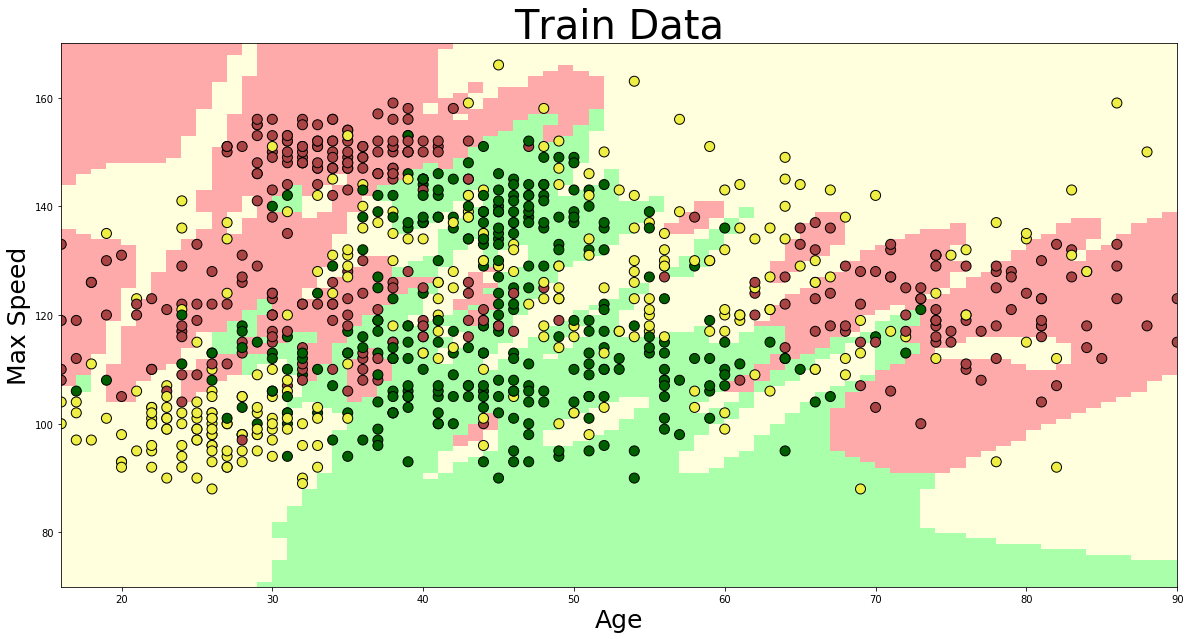

In [51]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

### Then for training data

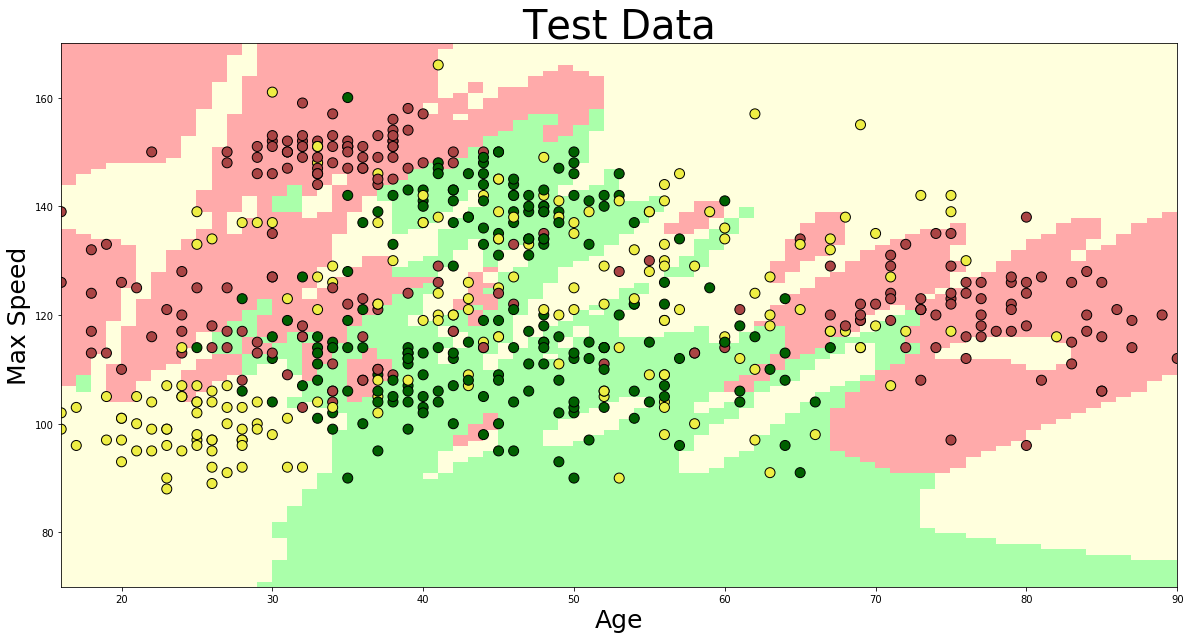

In [52]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

### A rule of thumb: Smoother decision boundaries imply less overfitting
This matches our observation: we detect overfitting and the decision boundaries also look rather wild, especially on the upper left side of the plot